In [137]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [138]:
data = load_breast_cancer()

In [139]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [140]:
df.shape

(569, 30)

In [141]:
X, y = data.data, data.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
population_size = 20
generations = 50
mutation_rate = 0.1
crossover_rate = 0.8

In [143]:
class CustomKNN:
    def __init__(self, n_neighbors=3, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)
    
    def _predict_single(self, x):
        distances = self._compute_distances(x)
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def _compute_distances(self, x):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(self.X_train - x), axis=1)
        else:
            raise ValueError("Unknown metric: " + self.metric)

In [144]:
def initialize_population():
    population = []
    for _ in range(population_size):
        chromosome = {
            'features': np.random.randint(0, 2, X_train.shape[1]),
            'k': np.random.randint(1, 15),
            'metric': np.random.choice(['euclidean', 'manhattan'])
        }
        population.append(chromosome)
    return population

In [145]:
def fitness(chromosome):
    selected_features = np.where(chromosome['features'] == 1)[0]
    if len(selected_features) == 0:
        return 0 
    model = CustomKNN(n_neighbors=chromosome['k'], metric=chromosome['metric'])
    model.fit(X_train[:, selected_features], y_train)
    predictions = model.predict(X_val[:, selected_features])
    accuracy = np.mean(predictions == y_val)
    return accuracy

In [146]:
def tournament_selection(population, fitness_scores, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        participants = np.random.choice(range(len(population)), tournament_size)
        best_idx = participants[np.argmax([fitness_scores[i] for i in participants])]
        selected.append(population[best_idx])
    return selected

In [147]:
def single_point_crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1['features']) - 1)
    child1_features = np.concatenate((parent1['features'][:point], parent2['features'][point:]))
    child2_features = np.concatenate((parent2['features'][:point], parent1['features'][point:]))
    
    child1 = {'features': child1_features, 'k': parent1['k'], 'metric': parent2['metric']}
    child2 = {'features': child2_features, 'k': parent2['k'], 'metric': parent1['metric']}
    return child1, child2

In [148]:
def mutate(chromosome, mutation_rate=0.1):
    for i in range(len(chromosome['features'])):
        if np.random.rand() < mutation_rate:
            chromosome['features'][i] = 1 - chromosome['features'][i]
    
    if np.random.rand() < mutation_rate:
        chromosome['k'] = np.clip(chromosome['k'] + np.random.randint(-2, 3), 1, 15)
    
    if np.random.rand() < mutation_rate:
        chromosome['metric'] = 'manhattan' if chromosome['metric'] == 'euclidean' else 'euclidean'
    
    return chromosome

In [149]:
population = initialize_population()
best_accuracy_progression = []

for gen in range(generations):
    # Evaluate fitness for each chromosome
    fitness_scores = [fitness(chrom) for chrom in population]
    best_accuracy_progression.append(max(fitness_scores))
    
    # Selection
    selected_population = tournament_selection(population, fitness_scores)
    
    # Crossover
    new_population = []
    for i in range(0, len(selected_population), 2):
        parent1 = selected_population[i]
        parent2 = selected_population[(i + 1) % len(selected_population)]
        if np.random.rand() < crossover_rate:
            child1, child2 = single_point_crossover(parent1, parent2)
        else:
            child1, child2 = parent1, parent2
        new_population.extend([child1, child2])
    
    # Mutation
    population = [mutate(chrom, mutation_rate) for chrom in new_population]
    
    # Print progress
    print(f"Generation {gen+1} - Best Accuracy: {max(fitness_scores):.4f}")


Generation 1 - Best Accuracy: 0.9708
Generation 2 - Best Accuracy: 0.9766
Generation 3 - Best Accuracy: 0.9766
Generation 4 - Best Accuracy: 0.9766
Generation 5 - Best Accuracy: 0.9766
Generation 6 - Best Accuracy: 0.9766
Generation 7 - Best Accuracy: 0.9766
Generation 8 - Best Accuracy: 0.9766
Generation 9 - Best Accuracy: 0.9766
Generation 10 - Best Accuracy: 0.9766
Generation 11 - Best Accuracy: 0.9766
Generation 12 - Best Accuracy: 0.9766
Generation 13 - Best Accuracy: 0.9766
Generation 14 - Best Accuracy: 0.9766
Generation 15 - Best Accuracy: 0.9766
Generation 16 - Best Accuracy: 0.9766
Generation 17 - Best Accuracy: 0.9766
Generation 18 - Best Accuracy: 0.9766
Generation 19 - Best Accuracy: 0.9766
Generation 20 - Best Accuracy: 0.9766
Generation 21 - Best Accuracy: 0.9766
Generation 22 - Best Accuracy: 0.9766
Generation 23 - Best Accuracy: 0.9766
Generation 24 - Best Accuracy: 0.9766
Generation 25 - Best Accuracy: 0.9825
Generation 26 - Best Accuracy: 0.9766
Generation 27 - Best 

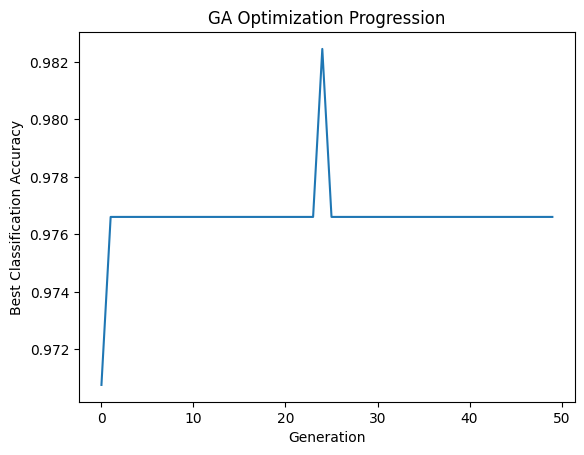

In [150]:
plt.plot(best_accuracy_progression)
plt.xlabel("Generation")
plt.ylabel("Best Classification Accuracy")
plt.title("GA Optimization Progression")
plt.show()

In [151]:
best_chromosome = population[np.argmax(fitness_scores)]
print("\nBest chromosome found:")
print("Selected Features:", np.where(best_chromosome['features'] == 1)[0])
print("k:", best_chromosome['k'])
print("Metric:", best_chromosome['metric'])
print("Best Accuracy:", max(fitness_scores))



Best chromosome found:
Selected Features: [ 0  2  3  4  5  7  8  9 11 14 15 17 19 21 22 23 24 25 26 29]
k: 11
Metric: euclidean
Best Accuracy: 0.9766081871345029
